The one-dimentional Schrodinger Equation is :

$$
- \frac{\hbar^2}{2m} \frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x)
$$


To start off, we import the required libraries :

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

**Constants and Parameters**

Given:
$$
\hbar = 1, \, m = 1, \, \alpha = 1, \, \lambda = 4
$$
The Schrödinger equation becomes:
$$
- \frac{1}{2} \frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x)
$$


Here,ℏ represents the reduced Planck constant, and 𝑚 is the mass of the particle. These values are normalized to 1.𝛼 and 𝜆 are parameters that shape the potential well, controlling its width and depth.

In [176]:
# Constants and Parameters
hbar = 1  # Planck constant
m = 1     # Particle mass
alpha = 1 # alpha parameter
lmbda = 4 # lambda parameter

**Potential Function**

The potential function 𝑉(𝑥) is the important part of the Schrödinger equation. It describes the external forces acting on the particle.

The potential \( V(x) \) is given by:
$$
V(x) = \frac{\hbar^2 \alpha^2}{2m} \lambda (\lambda - 1) \left( 0.5 - \frac{1}{\cosh^2(\alpha x)} \right)
$$


The term cosh(x), the hyperbolic cosine, shapes the potential well. At the center (x = 0), the potential reaches its minimum, and it symmetrically approaches zero as \( x→±∞ \). This creates a potential well where the particle is likely to be confined. The coefficient 
$$
\frac{\hbar^2 \alpha^2}{2m} \lambda (\lambda - 1)
$$
controls the depth of the well, with \(  𝜆= 4 \) making it relatively deep.



This function is implemented in Python as:


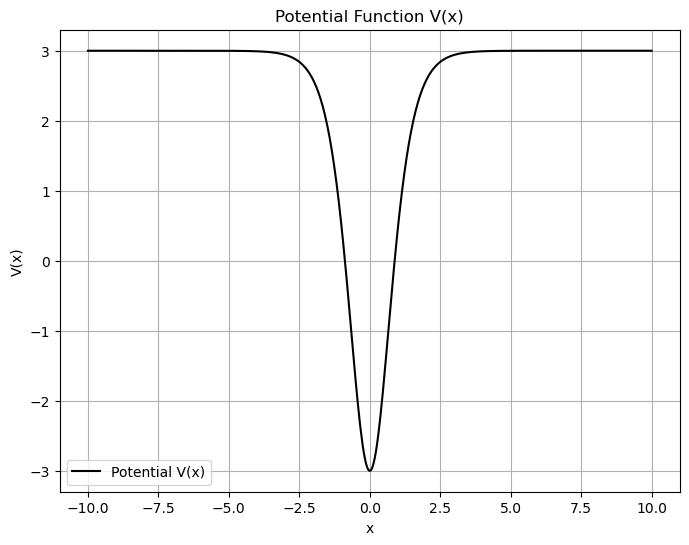

In [181]:
def V(x):
    coeff = (hbar**2 / (2 * m)) * alpha**2 * lmbda * (lmbda - 1)
    return coeff * (0.5 - 1 / (np.cosh(alpha * x)**2))

# Plot the potential
x = np.linspace(-10, 10, 500)
plt.figure(figsize=(8, 6))
plt.plot(x, V(x), label="Potential V(x)", color='black')
plt.title("Potential Function V(x)")
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid()
plt.legend()
plt.show()


When plotted, the potential well demonstrates a symmetric shape with a minimum at 𝑥=0. This is key to trapping quantum states.

**Numerov Method**

To solve the Schrödinger equation numerically, the code uses the **Numerov method**, which is specifically designed for second-order differential equations like:

$$
\psi''(x) + k(x)\psi(x) = 0, \quad \text{where } k(x) = \frac{2m}{\hbar^2} \left( E - V(x) \right)
$$

The Numerov method iteratively calculates the wavefunction \( \psi(x) \) at each point based on its previous values. The update equation is:

$$
\psi_{i+1} = \frac{2 \left( 1 - \frac{5h^2k_i}{12} \right)\psi_i - \left( 1 + \frac{h^2k_{i-1}}{12} \right)\psi_{i-1}}{1 + \frac{h^2k_{i+1}}{12}}
$$

Here:
- \( h \): Step size in the spatial grid.
- The function \( k(x) \) is defined as:

$$
k(x) = \frac{2m}{\hbar^2} \left( E - V(x) \right)
$$

where \( E \) is the trial energy and \( V(x) \) is the potential.


This function is implemented in Python as:


In [185]:
def numerov(psi0, psi1, E, x, h):
    N = len(x)
    psi = np.zeros(N)
    psi[0], psi[1] = psi0, psi1

    f = lambda xi: 2 * m / hbar**2 * (E - V(xi))
    for i in range(1, N - 1):
        k0 = f(x[i - 1])
        k1 = f(x[i])
        k2 = f(x[i + 1])
        psi[i + 1] = (2 * (1 - 5 * h**2 * k1 / 12) * psi[i] - (1 + h**2 * k0 / 12) * psi[i - 1]) / (1 + h**2 * k2 / 12)
    
    return psi


This method ensures a stable and accurate integration of 𝜓(𝑥).

**Matching Condition**

The wavefunctions computed using the Numerov method must satisfy continuity conditions. At a turning point (typically the midpoint of \( x \)), the wavefunction ψ(x) and its derivative ψ'(x) must match for the left and right integrations:

$$
\frac{\psi'(x_{\text{match}})}{\psi(x_{\text{match}})} \, \text{(left)} = \frac{\psi'(x_{\text{match}})}{\psi(x_{\text{match}})} \, \text{(right)}.
$$

To approximate the derivative, the code uses:

$$
\psi'(x) \approx \frac{\psi(x + h) - \psi(x - h)}{2h}.
$$

The matching condition is computed as:

$$
\text{ratio\_left} - \text{ratio\_right} = 0.
$$

This ensures that the wavefunctions meet seamlessly at the turning point. The code is :


In [189]:
def matching_condition(E, x, h):
    N = len(x)
    psi_left = numerov(0.0, 1e-5, E, x, h)
    psi_right = numerov(0.0, 1e-5, E, x[::-1], h)[::-1]
    x_match = N // 2
    ratio_left = (psi_left[x_match + 1] - psi_left[x_match - 1]) / (2 * h * psi_left[x_match])
    ratio_right = (psi_right[x_match + 1] - psi_right[x_match - 1]) / (2 * h * psi_right[x_match])
    return ratio_left - ratio_right


The matching condition is central to identifying valid eigenvalues.



**Root-Finding for Eigenvalues**

Eigenvalues \( E \) are found by solving the matching condition using Brent’s method. The root-finding algorithm searches for energies where the matching condition equals zero:

$$
f(E) = \text{ratio\_left} - \text{ratio\_right} = 0
$$

The code iterates through energy ranges to find multiple eigenvalues.


In [193]:
def find_eigenvalues(x, h, n_levels=3):
    eigenvalues = []
    E_start = [-5, 0, 2]
    E_end = [0, 5, 5]
    for n in range(n_levels):
        energies = np.linspace(E_start[n], E_end[n], 100)
        for i in range(len(energies) - 1):
            E1, E2 = energies[i], energies[i + 1]
            if matching_condition(E1, x, h) * matching_condition(E2, x, h) < 0:
                result = root_scalar(matching_condition, args=(x, h), bracket=[E1, E2], method='brentq')
                eigenvalues.append(result.root)
                break
    return eigenvalues

# Define the spatial grid and step size
x_min, x_max = -10, 10
h = 0.05
x = np.arange(x_min, x_max + h, h)

# Compute the first 3 eigenvalues
eigenvalues = find_eigenvalues(x, h, n_levels=3)


Finally, the potential and wavefunctions are plotted, with eigenvalues overlaid:

Numerical Eigenvalues:
E_0 = -1.500001
E_1 = 0.999998
E_2 = 2.499998


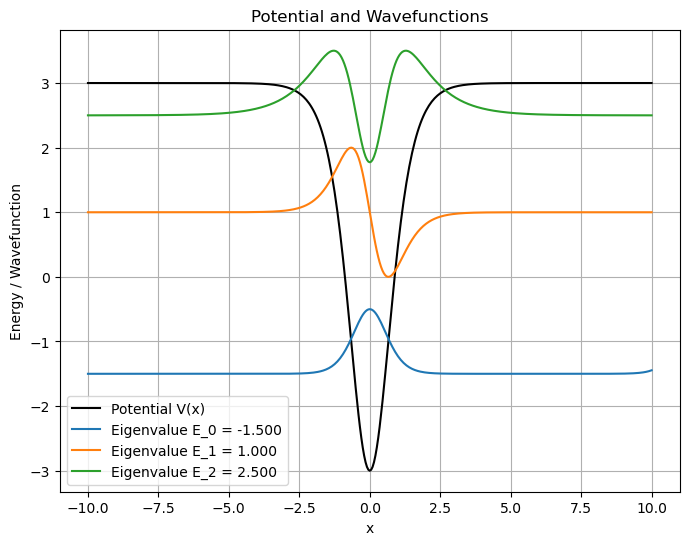

In [195]:
# Print the eigenvalues
print("Numerical Eigenvalues:")
for i, E in enumerate(eigenvalues):
    print(f"E_{i} = {E:.6f}")

plt.figure(figsize=(8, 6))

# Plot the potential
plt.plot(x, V(x), label="Potential V(x)", color='black')

# Plot the wavefunctions for each eigenvalue
for i, E in enumerate(eigenvalues):
    psi = numerov(0.0, 1e-5, E, x, h)  # Compute wavefunction using Numerov
    plt.plot(x, psi / np.max(np.abs(psi)) + E, label=f"Eigenvalue E_{i} = {E:.3f}")

# Add labels and title
plt.xlabel("x")
plt.ylabel("Energy / Wavefunction")
plt.title("Potential and Wavefunctions")
plt.legend()
plt.grid()
plt.show()



This shows the potential well, energy levels, and corresponding wavefunctions, providing a clear visualization of the quantum states.